<a href="https://colab.research.google.com/github/sakuragi-zero/yatteiki/blob/master/Transformer/Transformer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformerを理解  
次に単語の予測結果を返してビームサーチなどで独文を生成する  
Encoderは文章から意味を抽出する  
Decoderは意味を文章に戻す  
**Embedding**は単語をベクトルにする  
デコーダーは(1つ前の単語列を入力する(次単語予測))  
**PositionalEncoding**は単語の並びを記憶したベクトルを用意する(三角関数が使われる)  
単語の並びを記憶する工夫  

**MultiHeadAttention**は、どの情報に注目するべきか判断して情報を処理する    
**Add&LayerNomalization**  
Addはresidualconaction  
LayerNomalizationは学習高速化の正規化(バッチ版じゃなくてノーマライズド版)  
**FeedForwardNetwork**は2層のニューラルネットワークを系列ごとにアプライする  
注意：扱うベクトルは横ベクトルxW
式で定義すると  
$$
FNN(x)=ReLU(xW+b)W_2+b_2
$$  
デコーダーの最後の部分  
**linear**は単語次元のベクトル列  
線形写像にして確率にする  
**softmax**は確率(列)  
この流れを6回

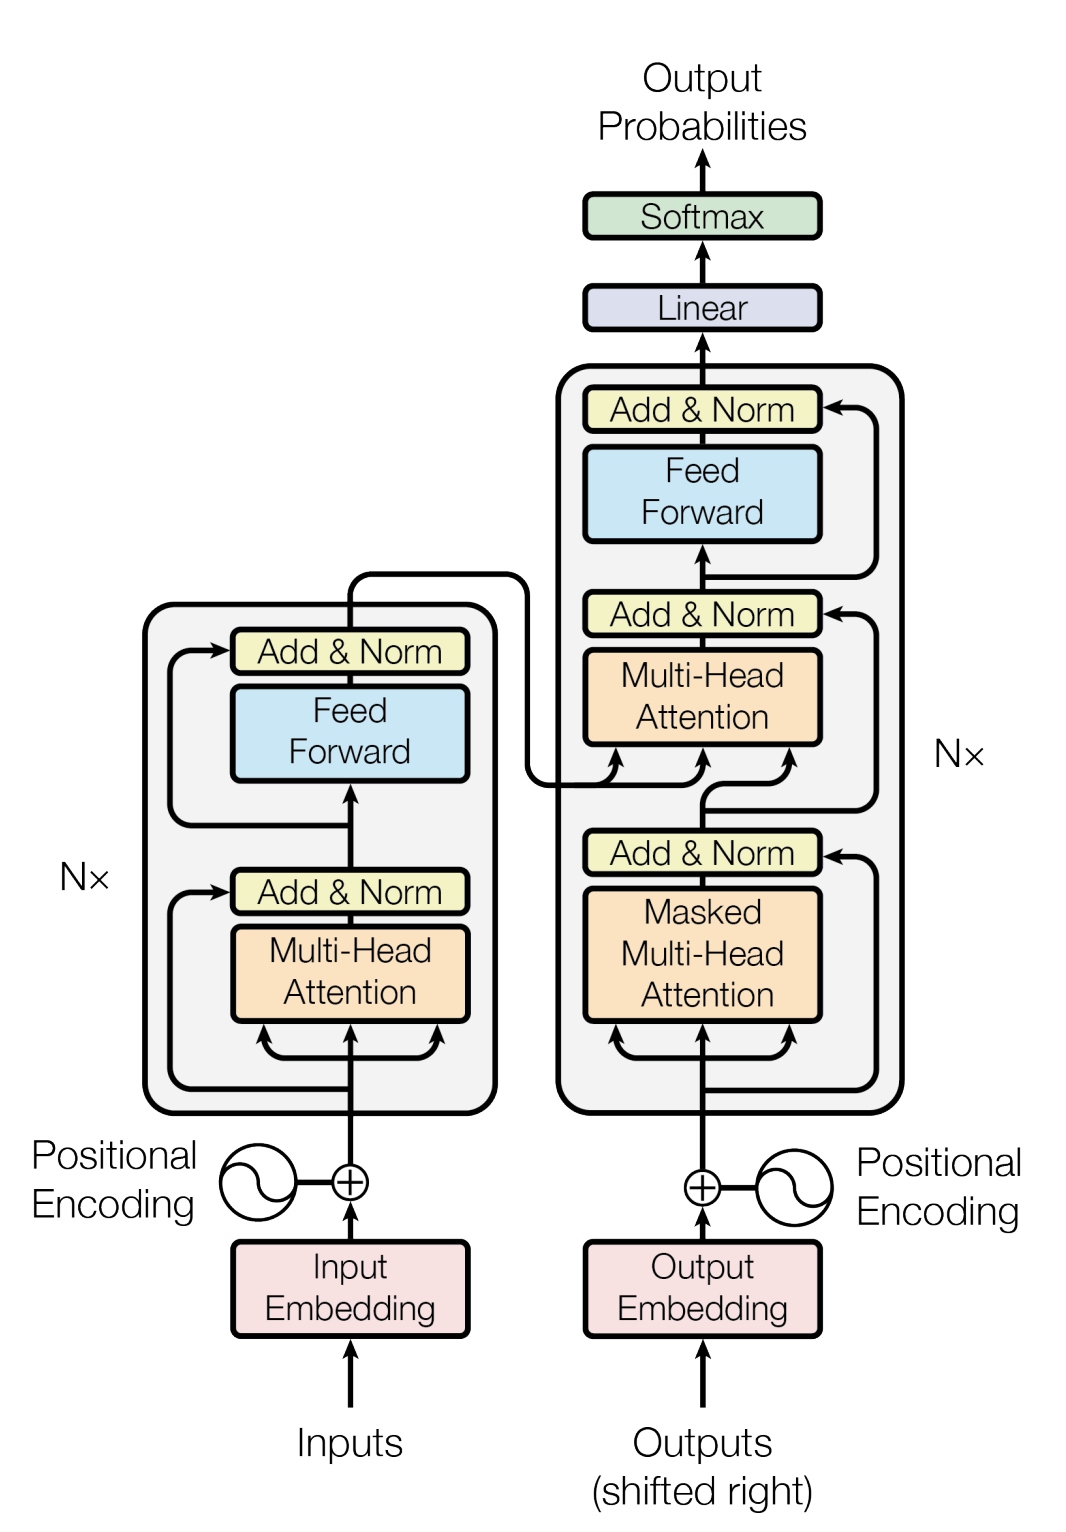

# MultiHeadAttentionを詳しく理解する

# Attention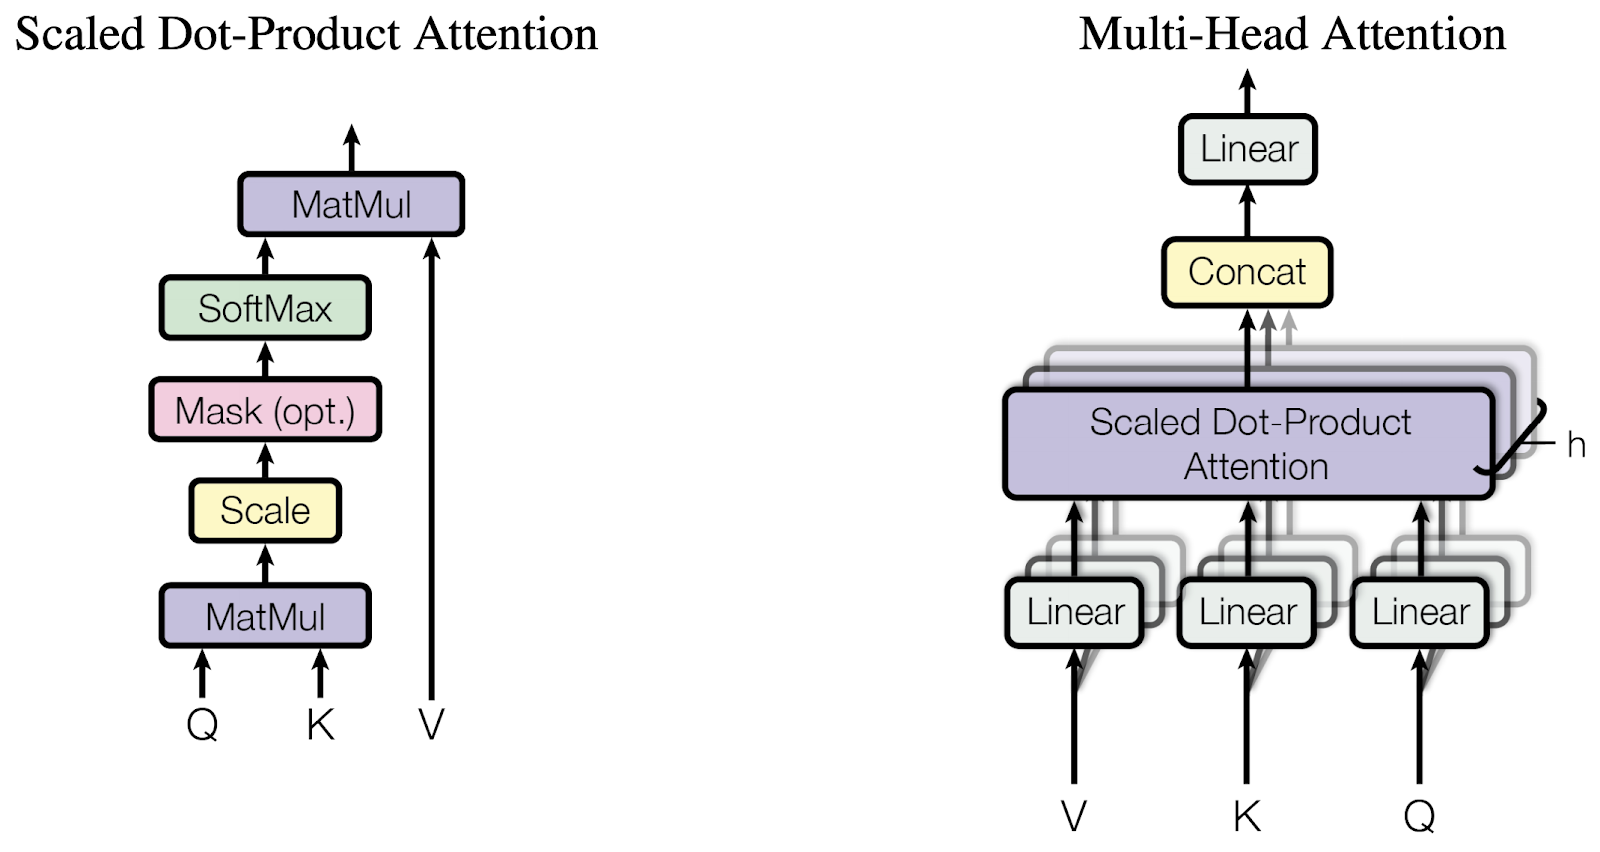

transformerはエンコーダーとデコーダーで構成されている  
transformerはRNNやCNNの代わりに複数の内積注意  
(multiple-scaled-dot-product-attention)で構成されるMulti-Head-Attentionを使用する

# Scaled dot product attention  
スケーリングされた内積注意関数はQ(query)、K(key)、V(value)の3つの入力を受け取る  
Attentionの重みは次の式で定義します  
$$
Attention(Q,K,V)=softmax_k(\frac{QK^T}{\sqrt{d_k}})V
$$  
バッチ処理の数式↑  
n個の入力  
$$
Q=(\begin{pmatrix}\vec{q_1} \\ \vec{q_2} \\ \vdots \\ \vec{q_n} \end{pmatrix})
$$  
　　　　
　　　　
$$
K=(\begin{pmatrix}\vec{k_1} \\ \vec{k_2} \\ \vdots \\ \vec{k_n} \end{pmatrix}
$$  
　　　　
　　　　
$$
V=(\begin{pmatrix}\vec{v_1} \\ \vec{v_2} \\ \vdots \\ \vec{v_n} \end{pmatrix}
$$  
KとVはペアxm個  


# 1個ずつの処理  
$$
Attention(\vec{q},K,V)=softmax(\frac{\vec{q}^t\!K}{\sqrt{d}})V
$$  
q転置kを見てみる。横ベクトルが縦に並んでいるものを  
縦ベクトルを横に並べたものに転置する  
ベクトルと行列の積を考えたい  
$$
\vec{q}^t\!K=(\vec{^t\!k_1},\vec{^t\!k_2}....\vec{^t\!k_m})
$$  
横と縦をかけて足す↓  
$$
\vec{q}^t\!k=(\vec{^t\!K_1},\vec{^t\!K_2}....\vec{^t\!K_m})
=(\vec{q}\vec{^t\!K_1},\vec{q}\vec{^t\!K_2}....\vec{q}\vec{^t\!K_m})
=(\vec{q}\cdot\vec{K_1},\vec{q}\cdot\vec{K_2},\vec{q}\cdot\vec{K_m})
$$  
　　　　　　　　　　　　　　　　　　　　　　　　　　内積が並ぶ↑  
内積を求める=**類似度**  
つまり与えられたQueryとKeyの類似度を取得する  
**重要**入力のQueryがどのKeyと似ているのか求める  
ルートdは次元を表す
**なぜ割るのか？**  
類似度を計算したベクトルがどんどん長くなるのでd=次元で割る  
最後にsoftmaxをかけて重みや割合に変換する  
$$
softmax(\frac{\vec{q}^t\!K}{\sqrt{d}})=(P_1....P_m)=\vec{P}
$$  
$$
softmax(\frac{\vec{q}^t\!K}{\sqrt{d}})V=\vec{P}V=\sum(P_i\vec{V_i})
$$  
最終的には**keyに1番近いvalueを選び取る！**これがScaled Dot Product Attention  


# まとめ  
Attention(q→K,V)ではqueryとkeyの類似度(q→,k→の内積)を計算して  
それに応じた重み(softmax(類似度))でvalueを足している  
q→とk→が似ている場合  
Pi=1 他は0となる  
**ここまでが1個のQueryに対する場合**  
**n個のQueryに対する場合は**  
$$
Attenstion(\vec{q},K,V)=softmax(\frac{\vec{q}^t\!K}{\sqrt{d}})V=\vec{P}V=\sum(P_i\vec{V_i})
$$  
　　　　　　　　　　　　　　　　　　　　　　　　　　↓  
$$
Q=(\begin{pmatrix}\vec{q_1} \\ \vec{q_2} \\ \vdots \\ \vec{q_n} \end{pmatrix}
$$  
　　　　　　　　　　　　　　　　　　　　　　　　　　↓

$$
Attention(Q,K,V)=softmax(\frac{Q^t\!K}{\sqrt{d}})V=((P_i\vec{V_i}...))
$$  
　　　　　　　　　　　　　　　　　　　　　　　(係数をまとめたもの↑)  
　　　　　　　　　　　　　　　　　　　　　　　　　　　(横ベクトルが縦にデータの個数分↑並んでいる)  
Qは入力で**KとVの学習が超重要!!**  
KとVが入力されたQueryを変換する役割を担っている  
**KとVの学習を行うのがMultiHeadAttention**

# MultiHeadAttention  
以下の数式で定義される  
$$
MultiHead(Q,K,V)=concat(head_i)W^o
$$  
$$
head_i=Attention(QW_i^q,KW_i^k,VW_i^v)
$$  
1つずつ分解してみていく  
$$
W_i^q,W_i^k,W_i^v部分は行列
$$  
行列をそれぞれ掛けているだけ 
掛けたものをAtttentionに突っ込む(横方向のベクトル) 
concatで複数の横ベクトルをつなげる  
最後にo=outputで行列を描ける  
headは8個用意する  
**なぜこんなこと(行列を掛ける)をするのか？**  
$$
(QW_i^q,KW_i^k,VW_i^v)
$$  

　　↑  
[#######]  
[#######]  
↑　↑ 　↑   
　V　K 　Q  
V,K,Qの入力値はXが入る  
V=K=Q=X  
このままだとVやKもXが1番似ている状況になる  
自分に似ているのは自分と言う感じになってします  
なので、ここで**行列を掛けてXを回転させる**  
詳しく見てみると...  
$$
Q=X〜XW_i^q
$$  
$$
K=X〜XW_i^k
$$  
$$
V=X〜XW_i^v
$$  
Xの横次元のベクトルを8個に切り分けてAttentionに突っ込むので  
Q=X〜XWiqのところで8等分したやつの  
1つ目：Xのどの部分を処理するのか決める  
2つ目：Xの注目の仕方を決める(行列を掛けて回転させてから内積を取る)  
3つ目：Xを回して出力の様子を調整する  
**まとめ**  
さまざまな角度からXの横ベクトルを比較して  
どこに注目するかを制御して出力を決定する。これがMultiHeadAttention  


参考にしたもの  

https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html  
https://www.youtube.com/watch?v=50XvMaWhiTY  